In [1]:
import pandas as pd
import torch
from torch import nn
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig
from tqdm import tqdm
import re
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

In [2]:
seq_path = r"E:\Archive\PG_at_UCL\bioinfo\homework\hw1\paralogs of PGH2.txt"
p_list = []
with open(seq_path, 'r') as f:
    contents = f.readlines()
    for content in contents:
        #content = content.strip()
        if re.match(r'\w', content):
            p_list.append(content)
print(len(p_list))


6


In [3]:
def Get_Protein_Feature(p_list, truncation_length:int = 2046):
    client = ESMC.from_pretrained("esmc_600m").to("cuda")
    batch = 20
    data_tmp = []
    output = []
    dictionary = {}
    for p in p_list:
        data_tmp.append(p)

    pbar0 = tqdm(range(len(data_tmp)//batch + 1), position=0, colour='cyan')
    for i in pbar0:
        torch.cuda.empty_cache()
        if i == len(data_tmp)//batch:
            data_part = data_tmp[i * batch:]
        else:
            data_part = data_tmp[i * batch:(i + 1) * batch]
        #proteins = [ESMProtein(sequence = s) for s in data_part]
        
        for p in data_part:
            proteins = ESMProtein(sequence = p)

            protein_tensors = client.encode(proteins)
            logits_output = client.logits(
                protein_tensors, 
                LogitsConfig(sequence=True, return_embeddings=True)
            )
            embbeding_output = logits_output.embeddings.squeeze().cpu().numpy().mean(0)
            dictionary[p] = embbeding_output
            df = pd.DataFrame(dictionary.items(), columns=['seq', 'esm'])
            #output.append(embbeding_output.squeeze())
    return df

df = Get_Protein_Feature(p_list)

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


In [4]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


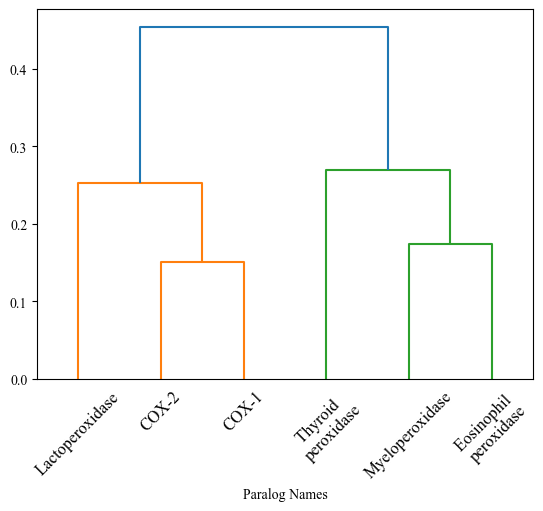

In [5]:
z = linkage(df['esm'].tolist(), 'ward')
f = fcluster(z,10000,'distance')
ax, fig = plt.subplots()

fig = dendrogram(
    z, 
    labels=[
        'COX-2', 'COX-1', 
        'Lactoperoxidase', 'Myeloperoxidase', 'Thyroid \nperoxidase', 'Eosinophil \nperoxidase'
    ], 
    leaf_rotation=45
)
plt.xlabel('Paralog Names')
plt.savefig('embedding_for_msa.png', dpi = 600, bbox_inches = 'tight')